# Simple simulation for Standard and Projection imaging

In [1]:
# @title Install and import packages
!pip install -q git+https://github.com/QI2lab/localize-psf.git
!pip install -q psfmodels
!pip install -q stackview ipycanvas==0.11

import numpy as np
from localize_psf import camera, fit_psf
from psfmodels import tot_psf
import stackview
from google.colab import output
try:
  import cupy as cp
except:
  xp = np
else:
  xp = cp

output.enable_custom_widget_manager()
rng = np.random.default_rng()

  Preparing metadata (setup.py) ... done


In [2]:
# @title Generate simulated object and PSF
z_footprint = 64
dxy_exp = .114
dz_exp = .114
dxy_gt = dxy_exp/3
dz_gt = dz_exp/3

gt_exp_xy_factor = int(dxy_exp/dxy_gt)
gt_exp_z_factor = int(dz_exp/dz_gt)
nxy_gt = 400 * gt_exp_xy_factor
nz_gt = z_footprint * gt_exp_z_factor

gt_image = np.random.rand(nz_gt,nxy_gt,nxy_gt).astype(np.float32)
gt_image[gt_image>=0.999999]=1.
gt_image[gt_image<0.999999]=0.

# microscope and PSF parameters
ex_NA = .01
em_NA = 1.35
ex_wvl = .488 # um
em_wvl = .515 # um

silicone_lens = {
    'ni0': 1.4, # immersion medium RI design value
    'ni': 1.4,  # immersion medium RI experimental value
    'ns': 1.33,  # specimen refractive index
    'tg': 170, # microns, coverslip thickness
    'tg0': 170 # microns, coverslip thickness design value
}
ex_lens = {**silicone_lens, 'NA': ex_NA}
ex_wvl = ex_wvl
em_lens = {**silicone_lens, 'NA': em_NA}
em_wvl = em_wvl
func = 'vectorial'

nx_psf = 127
nz_psf = 127

_, _, psf =tot_psf(nx=nx_psf, nz=nz_psf, dxy=dxy_gt, dz=dz_gt, pz=0,
                  x_offset=0, z_offset=0,
                  ex_wvl = ex_wvl, em_wvl = em_wvl,
                  ex_params=ex_lens, em_params=em_lens,
                  psf_func=func)

psf /= np.sum(psf,axis=(0,1,2)).astype(np.float32)

In [13]:
# @title Setup photon emission and exposure times
# @markdown # Camera limited simulation
#
# @markdown ##Supp. Fig 3A
#
# @markdown emission = 3000 photon/ms
#
# @markdown standard exposure = 1.7 ms
#
# @markdown projection exposure = 5.0 ms
#
# @markdown ~ 69 times faster projection imaging
#
# @markdown ##Supp. Fig 3B
#
# @markdown emission = 30000 photon/ms
#
# @markdown standard exposure = 1.7 ms
#
# @markdown projection exposure = 5.0 ms
#
# @markdown ~ 69 times faster projection imaging
#
# @markdown #Sample limited simulation
#
# @markdown ##Supp. Fig 3C
#
# @markdown emission = 300 photon/ms
#
# @markdown standard exposure = 2.0 ms
#
# @markdown projection exposure = 50.0 ms
#
# @markdown ~ 8 times faster projection imaging
#
# @markdown #Equal total photons simulation
#
# @markdown ##Supp. Fig 3D
#
# @markdown emission = 3000 photon/ms
#
# @markdown standard exposure = 2.0 ms
#
# @markdown projection exposure = 128.0 ms
#
# @markdown equal standard and projection imaging rate
Effective_emission_rate = 300 # @param {type:"number"}
eff_em_rate = Effective_emission_rate
Standard_per_plane_exposure_time_ms = 2 # @param {type:"slider", min:1.7, max:100, step:0.1}
exposure_time_standard = Standard_per_plane_exposure_time_ms
Projection_per_image_exposure_ms = 50 # @param {type:"slider", min:5, max:200, step:0.1}
exposure_time_projection = Projection_per_image_exposure_ms/z_footprint #ms



In [14]:
# @title Generate camera simulation for digitally projected image of full 3D volume

# blur on gt grid and then resample onto experimental XY grid
gt_blurred = fit_psf.blur_img_psf(xp.asarray(gt_image*eff_em_rate*exposure_time_standard),
                                  xp.asarray(psf),
                                  apodization=None).real
binned_blurred = camera.bin(xp.asarray(gt_blurred),(gt_exp_xy_factor,gt_exp_xy_factor))

# subsample in Z to simulate focus stacking
stack_binned_blurred = binned_blurred[::gt_exp_z_factor,:,:]

# apply photon shot noise and camera read noise to each image in volume
full_volume, snr = camera.simulated_img(ground_truth = xp.asarray(stack_binned_blurred),
                                      gains = 2.0,
                                      offsets = 100.,
                                      readout_noise_sds = 2.1,
                                      psf=None,
                                      photon_shot_noise=True)

# convert to 16-bit
full_volume = full_volume.astype(np.uint16)

# create digital sum projection of 3D volume
max_proj_image = np.sum(full_volume,axis=0).astype(np.uint16)

# clean up memory
del gt_blurred, binned_blurred, stack_binned_blurred
if xp == cp:
  cp._default_memory_pool.free_all_blocks()

In [15]:
# @title Generate camera simulation for optically projected image
# blur with psf on gt grid
gt_blurred_projection = fit_psf.blur_img_psf(xp.asarray(gt_image*eff_em_rate*exposure_time_projection),
                                            xp.asarray(psf),
                                            apodization=None).real
# project in z
blurred_projected = np.squeeze(np.sum(gt_blurred_projection,axis=0))

# resample onto experimental grid (only XY in this case)
binned_blurred_projected = np.squeeze(camera.bin(xp.expand_dims(xp.asarray(blurred_projected),0),
                                                 (gt_exp_xy_factor,gt_exp_xy_factor)))

# apply photon shot and camera readout noise
projected_image, projected_snr = camera.simulated_img(ground_truth = xp.asarray(binned_blurred_projected),
                                                      gains = 2.0,
                                                      offsets = 100.,
                                                      readout_noise_sds = 2.1,
                                                      psf=None,
                                                      photon_shot_noise=True)

# convert to 16-bit
projected_image = projected_image.astype(np.uint16)

# clean up memory
del gt_blurred_projection, blurred_projected, binned_blurred_projected
if xp == cp:
  cp._default_memory_pool.free_all_blocks()

In [16]:
# @title Display result side-by-side
# @markdown Left: Digitally projected sum for standard 3D volume
#
# @markdown Right: Projection imaging

stackview.curtain(max_proj_image, projected_image, continuous_update=True,zoom_factor=1.0)

StackViewNDArray([[6369, 6418, 6424, ..., 6382, 6401, 6383],
                  [6395, 6440, 6420, ..., 6394, 6383, 6389],
                  [6417, 6411, 6405, ..., 6423, 6395, 6410],
                  ...,
                  [6380, 6451, 6453, ..., 6417, 6400, 6389],
                  [6406, 6469, 6473, ..., 6416, 6415, 6424],
                  [6410, 6424, 6444, ..., 6405, 6392, 6403]], dtype=uint16)
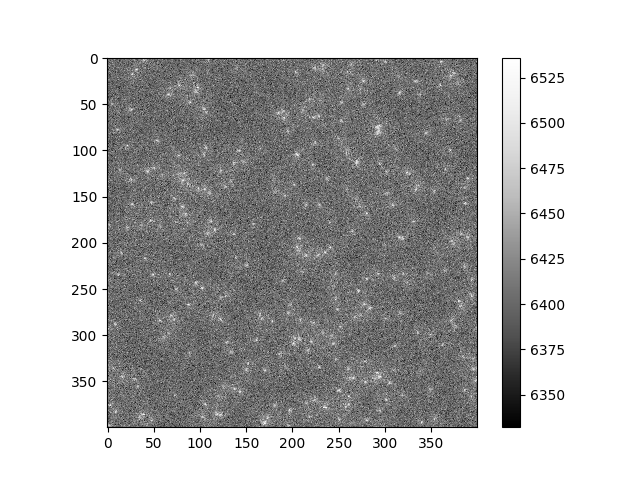
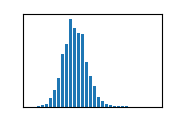

In [7]:
# @title Display digital sum projection for Standard image with histogram
stackview.insight(max_proj_image)


StackViewNDArray([[100, 106, 101, ..., 103, 100,  97],
                  [ 98, 102, 105, ...,  94, 100,  98],
                  [102,  98, 108, ..., 101, 102, 101],
                  ...,
                  [ 99,  98, 105, ..., 100,  97, 102],
                  [102, 105, 112, ...,  97, 104,  98],
                  [108, 104, 111, ..., 101,  99,  96]], dtype=uint16)
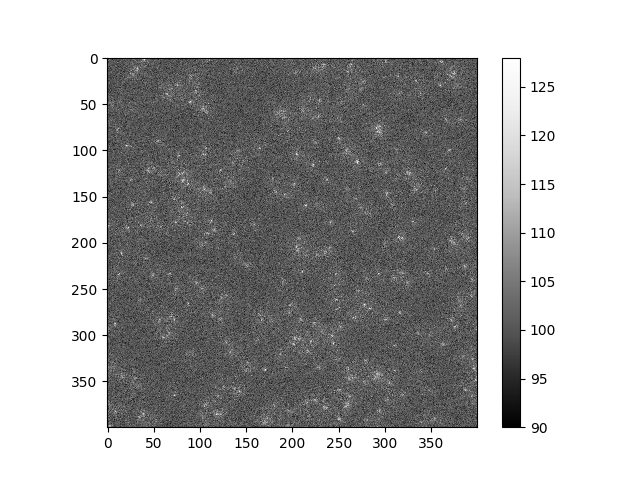
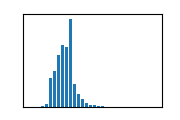

In [8]:
# @title Display Projection image with histogram
stackview.insight(projected_image)